In [1]:
import pandas as pd

df = pd.read_csv("../Data/OnlineRetail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df = df[df['Country'] == 'United Kingdom'].reset_index(drop=True)

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
from datetime import date

df_3m = df[(df['InvoiceDate'] < date(2011, 6, 1)) & (df['InvoiceDate'] >= date(2011, 3, 1))].reset_index(drop=True)
df_6m = df[(df['InvoiceDate'] >= date(2011, 6, 1)) & (df['InvoiceDate'] < date(2011, 12, 1))].reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


In [5]:
df_customer = pd.DataFrame(df_3m['CustomerID'].unique())
df_customer.columns = ['CustomerID']
df_customer.head()

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


In [6]:
df_max_purchase_date = df_3m.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_max_purchase_date.columns = ['CustomerID', 'MaxPurchaseDate']
df_max_purchase_date['Recency'] = (df_max_purchase_date['MaxPurchaseDate'].max() - 
                                   df_max_purchase_date['MaxPurchaseDate']).dt.days
df_customer = df_customer.merge(df_max_purchase_date[['CustomerID', 'Recency']], on='CustomerID')
df_customer.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [7]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=4)
k_means.fit(df_customer[['Recency']])
df_customer['RecencyCluster'] = k_means.predict(df_customer[['Recency']])
df_customer.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,12,0
1,14740.0,4,0
2,13880.0,25,3
3,16462.0,91,1
4,17068.0,11,0


In [8]:
df_ordered = df_customer.groupby('RecencyCluster')['Recency'].mean().to_frame().sort_values(by='Recency', ascending=False).reset_index()
df_ordered["index"] = df_ordered.index
df_ordered.drop('Recency', axis=1, inplace=True)
df_ordered = df_ordered.merge(df_customer, on="RecencyCluster")
df_ordered = df_ordered[['CustomerID', 'Recency', 'index']]
df_ordered.rename({'index': 'RecencyCluster'}, axis=1, inplace=True)
df_customer = df_ordered
df_customer.head()

,CustomerID,Recency,RecencyCluster
0,16462.0,91,0
1,16078.0,91,0
2,15709.0,91,0
3,12933.0,91,0
4,14506.0,91,0


In [9]:
df_frequency = df_3m.groupby('CustomerID')['InvoiceDate'].count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']
df_customer = df_customer.merge(df_frequency, on='CustomerID')
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,16462.0,91,0,1
1,16078.0,91,0,1
2,15709.0,91,0,6
3,12933.0,91,0,9
4,14506.0,91,0,38


In [10]:
k_means.fit(df_customer[['Frequency']])
df_customer['FrequencyCluster'] = k_means.predict(df_customer[['Frequency']])
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,16462.0,91,0,1,0
1,16078.0,91,0,1,0
2,15709.0,91,0,6,0
3,12933.0,91,0,9,0
4,14506.0,91,0,38,0


In [11]:
df_ordered = df_customer.groupby('FrequencyCluster')['Frequency'].mean().to_frame().sort_values(by='Frequency').reset_index()
df_ordered["index"] = df_ordered.index
df_ordered = df_ordered[['index', 'FrequencyCluster']]
df_ordered = df_ordered.merge(df_customer, on="FrequencyCluster")
df_ordered = df_ordered[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster']]
df_customer = df_ordered
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,16462.0,91,0,1,0
1,16078.0,91,0,1,0
2,15709.0,91,0,6,0
3,12933.0,91,0,9,0
4,14506.0,91,0,38,0


In [12]:
df_3m['Revenue'] = df_3m['UnitPrice'] * df_3m['Quantity']
df_revenue = df_3m.groupby('CustomerID')['Revenue'].sum()
df_customer = df_customer.merge(df_revenue, on='CustomerID')
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,16462.0,91,0,1,0,34.00
1,16078.0,91,0,1,0,79.20
2,15709.0,91,0,6,0,133.25
3,12933.0,91,0,9,0,109.50
4,14506.0,91,0,38,0,297.16


In [13]:
k_means.fit(df_customer[['Revenue']])
df_customer['RevenueCluster'] = k_means.predict(df_customer[['Revenue']])
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,16462.0,91,0,1,0,34.00,0
1,16078.0,91,0,1,0,79.20,0
2,15709.0,91,0,6,0,133.25,0
3,12933.0,91,0,9,0,109.50,0
4,14506.0,91,0,38,0,297.16,0


In [14]:
df_ordered = df_customer.groupby('RevenueCluster')['Revenue'].mean().to_frame().sort_values(by='Revenue').reset_index()
df_ordered["index"] = df_ordered.index
df_ordered = df_ordered[['index', 'RevenueCluster']]
df_ordered = df_ordered.merge(df_customer, on="RevenueCluster")
df_ordered = df_ordered[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Revenue', 'RevenueCluster']]
df_customer = df_ordered
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,16462.0,91,0,1,0,34.00,0
1,16078.0,91,0,1,0,79.20,0
2,15709.0,91,0,6,0,133.25,0
3,12933.0,91,0,9,0,109.50,0
4,14506.0,91,0,38,0,297.16,0


In [15]:
df_customer.sort_values(by=['RecencyCluster', 'FrequencyCluster', 'RevenueCluster'], ascending=False).head(10)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
1830,16422.0,4,3,129,3,10348.13,2
1831,13694.0,0,3,159,3,15570.47,2
1832,13798.0,4,3,122,3,11105.20,2
1833,17511.0,14,3,199,3,17307.53,2
1834,16684.0,13,3,73,3,15263.96,2
1796,12971.0,4,3,73,3,2962.65,1
1797,16839.0,4,3,73,3,3729.42,1
1798,15622.0,5,3,150,3,2506.75,1
1799,15189.0,5,3,75,3,3252.04,1
1800,13767.0,7,3,112,3,3019.22,1


In [16]:
df_customer['OverallScore'] = df_customer['RecencyCluster'] + df_customer['FrequencyCluster'] + df_customer['RevenueCluster']
df_customer['Segment'] = 'Low-Value'
df_customer.loc[df_customer['OverallScore'] > 2, 'Segment'] = 'Mid-Value' 
df_customer.loc[df_customer['OverallScore'] > 4, 'Segment'] = 'High-Value'
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,16462.0,91,0,1,0,34.00,0,0,Low-Value
1,16078.0,91,0,1,0,79.20,0,0,Low-Value
2,15709.0,91,0,6,0,133.25,0,0,Low-Value
3,12933.0,91,0,9,0,109.50,0,0,Low-Value
4,14506.0,91,0,38,0,297.16,0,0,Low-Value


In [17]:
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_customer_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_customer_6m.columns = ['CustomerID', 'm6_Revenue']
df_customer_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


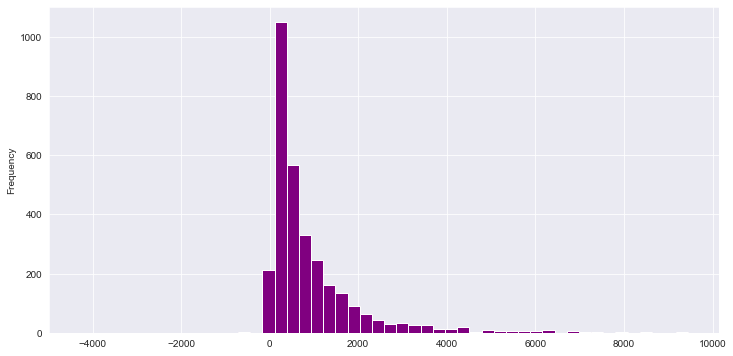

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
df_customer_6m[df_customer_6m['m6_Revenue'] < 10000]['m6_Revenue'].plot(kind="hist", figsize=(12, 6), color="purple", bins=50)
plt.show()

In [19]:
df_customer = df_customer.merge(df_customer_6m, on='CustomerID')
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,16462.0,91,0,1,0,34.00,0,0,Low-Value,68.00
1,12933.0,91,0,9,0,109.50,0,0,Low-Value,496.78
2,14506.0,91,0,38,0,297.16,0,0,Low-Value,1445.31
3,16212.0,89,0,32,0,489.00,0,0,Low-Value,192.19
4,17027.0,91,0,4,0,-28.50,0,0,Low-Value,446.41


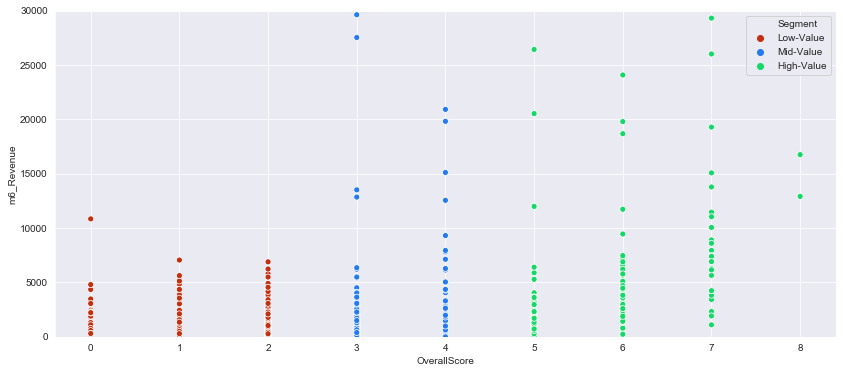

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 6))
sns.scatterplot(x='OverallScore', y='m6_Revenue', data=df_customer, hue='Segment', 
                palette=sns.color_palette(["#C23011", "#247AEE", "#16D869"]))
plt.ylim([0, 30000])
plt.show()

In [21]:
k_means = KMeans(n_clusters=3)
k_means.fit(df_customer[['m6_Revenue']])
df_customer['LTV_Cluster'] = k_means.predict(df_customer[['m6_Revenue']])
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTV_Cluster
0,16462.0,91,0,1,0,34.00,0,0,Low-Value,68.00,0
1,12933.0,91,0,9,0,109.50,0,0,Low-Value,496.78,0
2,14506.0,91,0,38,0,297.16,0,0,Low-Value,1445.31,0
3,16212.0,89,0,32,0,489.00,0,0,Low-Value,192.19,0
4,17027.0,91,0,4,0,-28.50,0,0,Low-Value,446.41,0


In [22]:
df_ordered = df_customer.groupby('LTV_Cluster')['m6_Revenue'].mean().to_frame().sort_values(by='m6_Revenue').reset_index()
df_ordered["index"] = df_ordered.index
df_ordered = df_ordered[['index', 'LTV_Cluster']]
df_ordered = df_ordered.merge(df_customer, on="LTV_Cluster")
df_ordered = df_ordered[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Revenue', 
                         'RevenueCluster', 'OverallScore', 'Segment', 'm6_Revenue', 'index']]
df_ordered.rename({'index': 'LTV_Cluster'}, axis=1, inplace=True)
df_customer = df_ordered
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTV_Cluster
0,16462.0,91,0,1,0,34.00,0,0,Low-Value,68.00,0
1,12933.0,91,0,9,0,109.50,0,0,Low-Value,496.78,0
2,14506.0,91,0,38,0,297.16,0,0,Low-Value,1445.31,0
3,16212.0,89,0,32,0,489.00,0,0,Low-Value,192.19,0
4,17027.0,91,0,4,0,-28.50,0,0,Low-Value,446.41,0


In [23]:
df_customer.groupby('LTV_Cluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTV_Cluster,,,,,,,,
0,1364.0,1337.930917,1563.105332,-609.40,366.4225,823.55,1693.225,11992.40
1,25.0,23243.670400,9132.653058,12556.39,15115.6000,20530.00,29313.150,45269.64
2,2.0,155893.190000,34755.514519,131317.33,143605.2600,155893.19,168181.120,180469.05


In [24]:
df_customer.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTV_Cluster
0,16462.0,91,0,1,0,34.0,0,0,Low-Value,68.00,0
1,12933.0,91,0,9,0,109.5,0,0,Low-Value,496.78,0


In [25]:
df = pd.get_dummies(df_customer)

corr_matrix = df.corr()
corr_matrix['LTV_Cluster'].sort_values(ascending=False)

LTV_Cluster           1.000000
m6_Revenue            0.786399
Revenue               0.773212
RevenueCluster        0.653827
Frequency             0.269384
OverallScore          0.242675
Segment_High-Value    0.206294
RecencyCluster        0.126954
FrequencyCluster      0.096104
Segment_Mid-Value     0.010772
CustomerID           -0.003058
Recency              -0.124499
Segment_Low-Value    -0.152565
Name: LTV_Cluster, dtype: float64

In [29]:
from sklearn.model_selection import train_test_split

x = df.drop(['LTV_Cluster', 'm6_Revenue'], axis=1)
y = df['LTV_Cluster']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [30]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', n_jobs=-1).fit(x_train, y_train)

print("Accuracy", xgb.score(x_train, y_train))
print("Accuracy on test set", xgb.score(x_test[x_train.columns], y_test))

res = xgb.predict(x_test)
print(classification_report(y_test, res))

Accuracy 0.998972250770812
Accuracy on test set 0.9904306220095693
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       414
           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         1

    accuracy                           0.99       418
   macro avg       0.48      0.66      0.53       418
weighted avg       0.99      0.99      0.99       418



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
